<a href="https://colab.research.google.com/github/AdamStajer07/pytorchTutorial/blob/main/03_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

src:
https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluting a model (interface)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (interface)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything.. in ml
* Excel speadsheet
* Images of any kind
* Videos
* Audio
* Text
* etc

ML is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation

In [3]:
# let's create a data using linear regresion (y = ax + b)

weight = 0.7 #a
bias = 0.3 #b

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #x
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Spliting data into training and test sets (!IMPORTANT)

In [4]:
 # Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
#Visualize train data with matplotlib

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

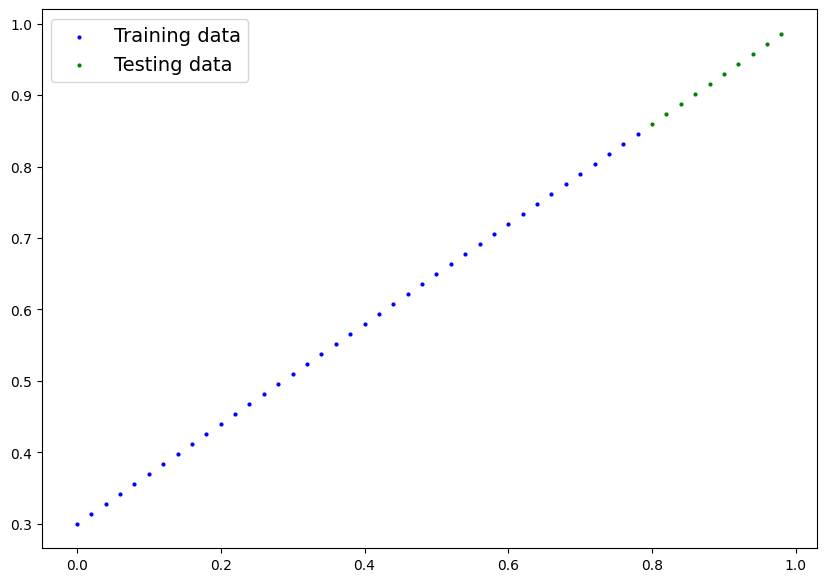

In [6]:
plot_predictions()

## 2. Build model

What model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values

Two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Foward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### Pytorch model building essentials

* torch.nn -  contains all of the buildings for computational graphs ( a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters shuld our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the oprimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require tou to oerwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

.parameters()

In [8]:
# Create a random seed
torch.manual_seed(42)

#Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

In [48]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.6575],
        [0.6658],
        [0.6741],
        [0.6824],
        [0.6907],
        [0.6990],
        [0.7073],
        [0.7156],
        [0.7238],
        [0.7321]])

In [11]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

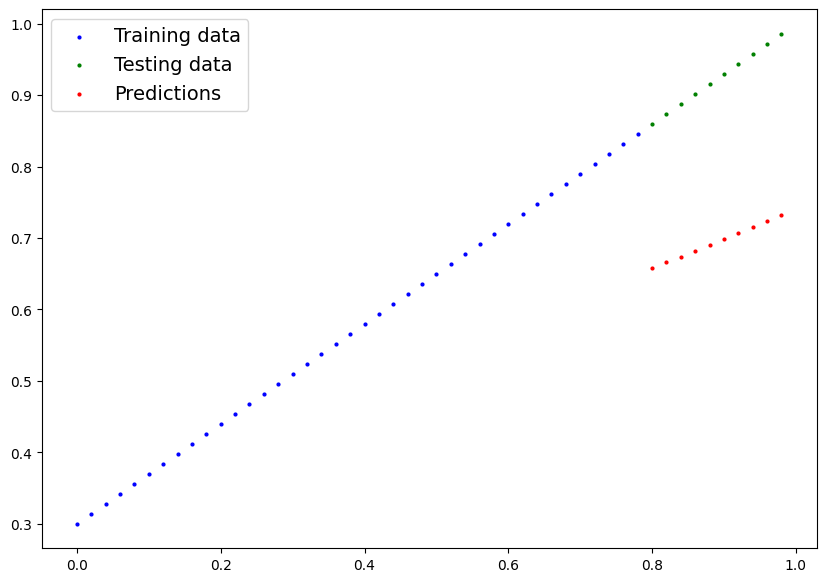

In [49]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters. Or in other words from a poor repsresentation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:

* **Loss function:** a function to measure how wrong your model's predictions are to the ideal outputs, lower is better

* **Optimizer**: takes into account the loss of a model and adjusts the model's
parameter (e.g. weight & bias) to improve the loss function

And specifically for PyTorch we need:
* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

in training loop we need:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [18]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [14]:
model_0.state_dict()
#OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [59]:
# An epoch is one loop through the data... (this is a hyperparameter cause we've set itself)
epochs = 10

### Training
#0. Loop through the data
for epoch in range(epochs):
  #Set the model to training mode
  model_0.train() #train mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss

  loss = loss_fn(y_pred, y_train)
  print(f"loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # By default how the optimizre changes will acculumate through the loop so... we have to zero them above in step 3 iteration of the loop

  ### Testing
  model_0.eval() #turns off gradient tracking
model_0.state_dict()

loss: 0.010716589167714119
loss: 0.010375778190791607
loss: 0.010031387209892273
loss: 0.009686763398349285
loss: 0.009346187114715576
loss: 0.008997755125164986
loss: 0.008660981431603432
loss: 0.008311985060572624
loss: 0.007972544990479946
loss: 0.007626785431057215


OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

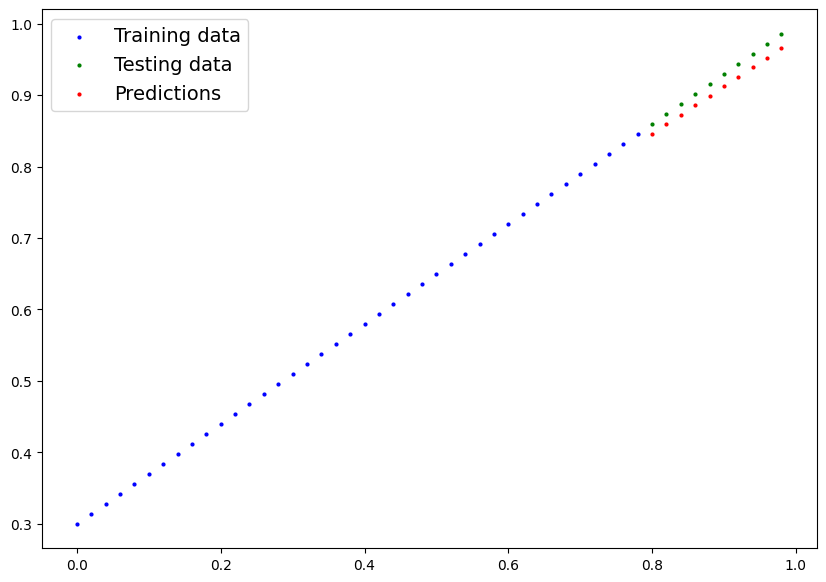

In [60]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)